In [ ]:
from jax import grad, vmap, value_and_grad
import jax.numpy as jnp
from jax.nn import relu
import numpy as np
from jax import random
import matplotlib.pyplot as plt
%matplotlib inline

**Prepare a simulated dataset**

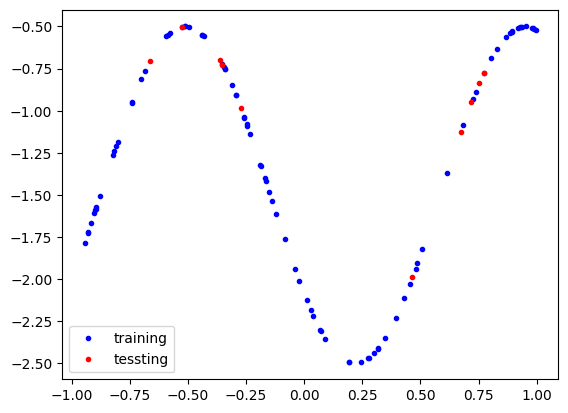

In [ ]:
# number of data points,
num_data = 100
train_data_ratio = 0.9
train_num = int(num_data * train_data_ratio)

# generate data
x = np.random.uniform(-1, 1, size=(num_data, 1)) # 1-dim data

# ground truth curve
t = 2.2
w = 4.3
b = -1.5
y = jnp.cos(w * x + t) + b

# data split
train_x = x[:train_num, :]
train_y = y[:train_num, :]
test_x = x[train_num:, :]
test_y = y[train_num:, :]

data = dict([('train_x', train_x), ('train_y', train_y), ('test_x', test_x), ('test_y', test_y)])

plt.plot(data['train_x'], data['train_y'], '.b', label='training')
plt.plot(data['test_x'], data['test_y'], '.r', label='tessting')
plt.legend()


**Build up neural network:**



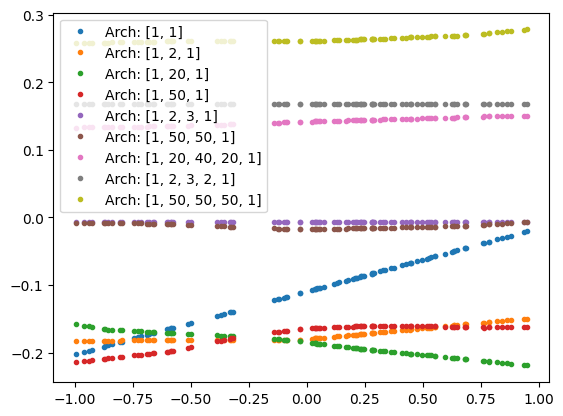

In [ ]:
def relu(x):
  ''' Activation Function '''
  return x * (x > 0)

def net(params, x):
      h = x
      for i in range(len(params) - 1):  # Loop through each layer except the last one
        w, b = params[i]
        h = jnp.matmul(h, w.T) + b
        h = relu(h)

    # For the last layer, do not apply activation
      w, b = params[-1]
      y = jnp.matmul(h, w.T) + b
      return y


def initialize_params(sizes, scale=1e-1, seed=1):
    ''' Initialize the weights of all layers of a linear layer network '''
    '''sizes=[input_dim, hidden_dim, output_dim]'''

    key = random.PRNGKey(seed)
    keys = random.split(key, len(sizes))

    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_layer(m, n, key, scale):
        w_key, b_key = random.split(key)
        return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

    return [initialize_layer(m, n, k, scale) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

x = np.random.uniform(-1, 1, size=(100, 1)) # 1-dim data

layer_sizes = [
    [1, 1],
    [1, 2, 1],
    [1, 20, 1],
    [1, 50, 1] ,
    [1, 2, 3, 1],
    [1, 50, 50, 1],
    [1, 20, 40, 20, 1],
    [1, 2, 3, 2, 1],
    [1, 50, 50, 50, 1]
]

for layer_size in layer_sizes:
    params_rnd = initialize_params(layer_size, 1e-1, 1)
    ypred = net(params_rnd, x)
    plt.plot(x, ypred, '.', label=f"Arch: {layer_size}")

plt.legend()
# Return a list of tuples of layer weights
# params_rnd = initialize_params(layer_sizes, seed=1, scale=1e-1)

# # plot some neural networks with random weights.

# ypred = net(params_rnd, x)
# plt.plot(x, ypred, '.')
# ypred = net(initialize_params(layer_sizes, seed=10), x)
# plt.plot(x, ypred, '.')
# ypred = net(initialize_params(layer_sizes, seed=100), x)
# plt.plot(x, ypred, '.')


2a)  I saw that the larger the number of layers the higher the y predicted value was.I tried 3, 4, and 5 layers with various higgen layers containing 2 - 50 neurons. When there was one input and one put the result was linear. Generally, the greater the number of layers and neurons, the greater the result.

2b) # With a very small σ(10^-5), the neural network weights are initialized very close to zero. When the weights are too small, the output from the neurons will also be small,and this leads to gradients that are increasingly small which leads to the "vanishing gradients" problem. If σ is too large (10^2), the network will produce large output values, leading to large gradients which leads to "exploding gradients," where weight updates are too large, and the model fails to converge or diverges diverges.With a moderate σ(10^-1). An initialization strategy that helps prevent the vanishing gradient problem is the Xavier/Glorot Initialization which sets σ based on the number of input and output neurons for each layer. It helps keep the variance in the activations roughly the same across different layers in a deep network.

**Gradient descent**

In [ ]:
def mse_loss(params, x, y):
    ''' Define the loss function with MSE loss '''
    pred = net(params, x)
    return jnp.mean((pred - y) ** 2)

#  One step of gradient descent
def gd_step(params, loss_fun, x, y, step_size = 1e-1):
    ''' Calculate gradient and update the parameters '''

    # calculate the loss and gradient
    loss, gradients = value_and_grad(loss_fun)(params, x, y)

    # gradient descent step
    params_new = []
    for param, gradient in zip(params, gradients):
        param = list(param)
        param[0] -= step_size * gradient[0]
        param[1] -= step_size * gradient[1]
        param = tuple(param)
        params_new.append(param)
    return params_new, loss

# Gradient descent main algorithm
def gd_train(params_initial, loss_fun, model, data, step_size=1e-1, steps=200):
  # initialization
  params = params_initial
  Losses_train = []
  Losses_test = []
  Pred = []

  # main loop
  for i in range(steps):
    params, loss_train= gd_step(params, loss_fun, data['train_x'], data['train_y'], step_size=step_size)
    loss_test = loss_fun(params, data['test_x'], data['test_y'])

    Losses_train.append(loss_train)
    Losses_test.append(loss_test)
    Pred.append(model(params, data['train_x']))
    if i % 100 == 0:
      print('Step {} | Training Loss:{:.2f} | Testing Loss:{:.2f}'.format(i, loss_train, loss_test))

  trajectory = dict([('training_loss', Losses_train), ('testing_loss', Losses_test), ('train_y_pred', Pred)])
  return params, trajectory


trajectories = {}

for beta in betas:
    print(f"Training with beta = {beta}")
    _, trajectory = gd_train(params_initial, mse_loss, net, data, step_size=1e-1, steps=200, beta=beta)
    trajectories[beta] = trajectory
plt.figure(figsize=(12, 6))

for beta, traj in trajectories.items():
    plt.plot(traj['training_loss'], label=f"Training Loss (beta={beta})")
    #plt.plot(traj['testing_loss'], '--', label=f"Testing Loss (beta={beta})")

plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Losses for Different Betas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Main training loop:**

Step 0 | Training Loss:2.12 | Testing Loss:1.03
Step 100 | Training Loss:0.30 | Testing Loss:0.29
Step 200 | Training Loss:0.16 | Testing Loss:0.18
Step 300 | Training Loss:0.13 | Testing Loss:0.16
Step 400 | Training Loss:0.11 | Testing Loss:0.13
Step 500 | Training Loss:0.08 | Testing Loss:0.10
Step 600 | Training Loss:0.06 | Testing Loss:0.06
Step 700 | Training Loss:0.04 | Testing Loss:0.04
Step 800 | Training Loss:0.02 | Testing Loss:0.02
Step 900 | Training Loss:0.02 | Testing Loss:0.02


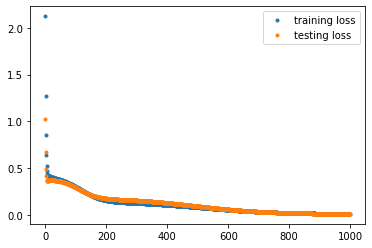

In [ ]:
params_initial = initialize_params(layer_sizes, seed=1, scale=1e-1)
loss_fun = mse_loss
model = net
params, trajectory = gd_train(params_initial, loss_fun, model, data, step_size=1e-1, steps=1000)

plt.plot(trajectory['training_loss'], '.', label='training loss')
plt.plot(trajectory['testing_loss'], '.', label='testing loss')
plt.legend()

**Visualize the fitting process:**

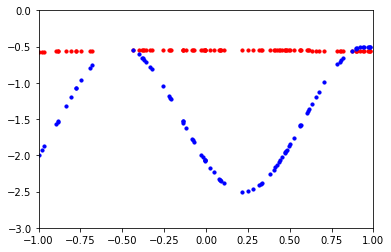

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def show_cartoon(data, trajectory):
  fig, ax = plt.subplots()
  def animate(frame_num):
    ax.clear()
    ax.scatter(data['train_x'], trajectory['train_y_pred'][10 * frame_num], color = 'r', s=10, label='Training Prediction')
    ax.scatter(data['train_x'], data['train_y'], color = 'b', s = 10, label='Groud Truth')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-3, 0)

  anim = FuncAnimation(fig, animate, frames=100, interval=60)
  return anim


anim = show_cartoon(data, trajectory)
HTML(anim.to_html5_video())
